In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

df.head()



,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)


df_1  = df1.merge(df2, on='id',how='left') # merging two data frames

In [4]:
df_1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [7]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [8]:
questions = list(df['question1']+df['question2']) 

In [9]:
y_true = df['is_duplicate']

In [14]:
x_train,x_test, y_train, y_test = train_test_split(questions, y_true, stratify=y_true, test_size=0.3)

<h1>4. Machine Learning Models </h1>

In [15]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [16]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

In [17]:
# Using a TFIDF model

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(x_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_tfidf = vectorizer_tfidf.transform(x_train)
x_test_tfidf = vectorizer_tfidf.transform(x_test)

print("After vectorizations")
print(x_train_tfidf.shape, y_train.shape)
print(x_test_tfidf.shape, y_test.shape)
print("="*100)


After vectorizations
(283003, 74159) (283003,)
(121287, 74159) (121287,)


Log loss on Test Data using Random Model 0.8854176176806083


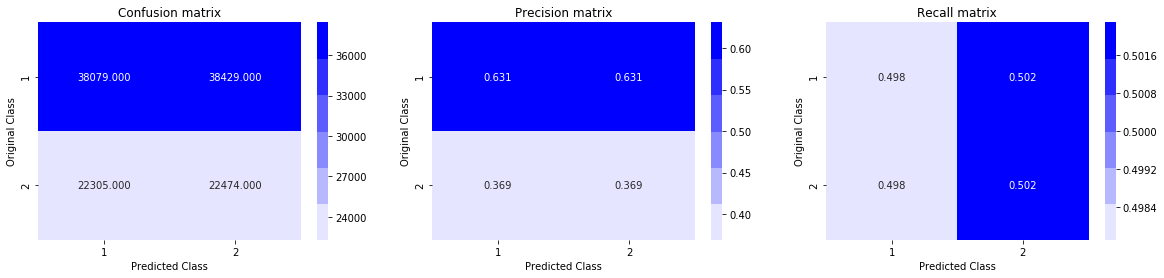

In [18]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5049542441493327
For values of alpha =  0.0001 The log loss is: 0.533963517852245
For values of alpha =  0.001 The log loss is: 0.566681116541915
For values of alpha =  0.01 The log loss is: 0.5801836238072913
For values of alpha =  0.1 The log loss is: 0.6275732905774358
For values of alpha =  1 The log loss is: 0.6397819238793043
For values of alpha =  10 The log loss is: 0.6409699955626325


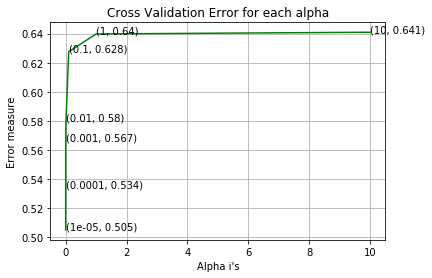

For values of best alpha =  1e-05 The train log loss is: 0.4856300965114643
For values of best alpha =  1e-05 The test log loss is: 0.5049542441493327
Total number of data points : 121287


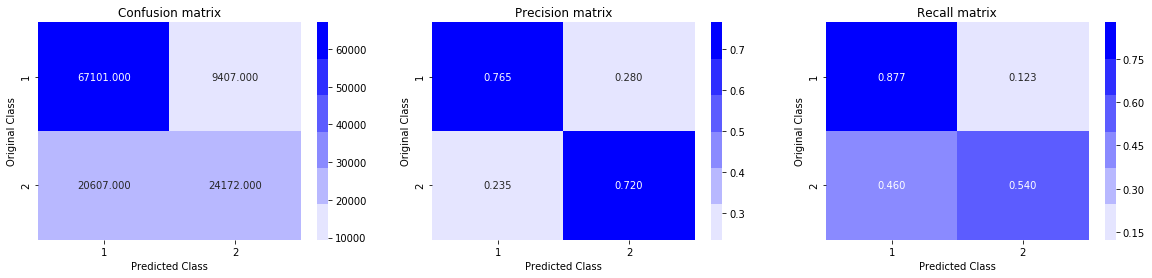

In [19]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(x_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(x_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5207151697373714
For values of alpha =  0.0001 The log loss is: 0.5753464033074854
For values of alpha =  0.001 The log loss is: 0.6384694285480111
For values of alpha =  0.01 The log loss is: 0.6585278256322725
For values of alpha =  0.1 The log loss is: 0.6585278256322611
For values of alpha =  1 The log loss is: 0.6585278256322723
For values of alpha =  10 The log loss is: 0.6585278256322723


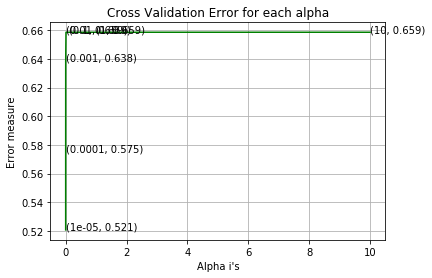

For values of best alpha =  1e-05 The train log loss is: 0.5062903033329691
For values of best alpha =  1e-05 The test log loss is: 0.5207151697373714
Total number of data points : 121287


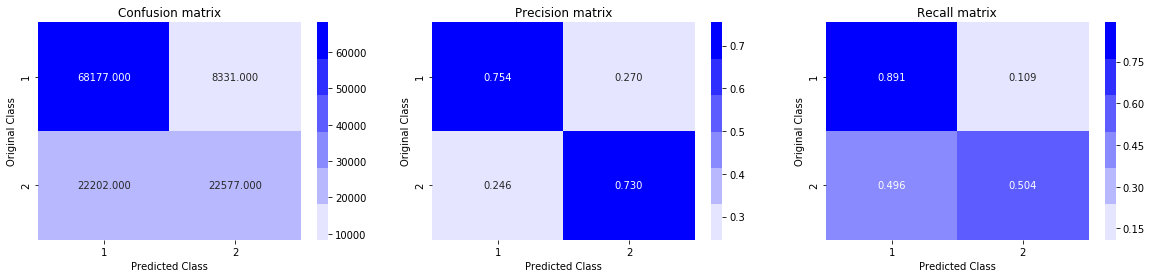

In [20]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(x_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(x_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [21]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train_tfidf, label=y_train)
d_test = xgb.DMatrix(x_test_tfidf, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_train_tfidf,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.690632	valid-logloss:0.690677
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.669949	valid-logloss:0.670403
[20]	train-logloss:0.654646	valid-logloss:0.65545
[30]	train-logloss:0.643056	valid-logloss:0.644092
[40]	train-logloss:0.634015	valid-logloss:0.635275
[50]	train-logloss:0.626692	valid-logloss:0.628139
[60]	train-logloss:0.620725	valid-logloss:0.622321
[70]	train-logloss:0.615673	valid-logloss:0.617401
[80]	train-logloss:0.611235	valid-logloss:0.613118
[90]	train-logloss:0.607379	valid-logloss:0.60937
[100]	train-logloss:0.60395	valid-logloss:0.606048
[110]	train-logloss:0.600871	valid-logloss:0.603082
[120]	train-logloss:0.59807	valid-logloss:0.600395
[130]	train-logloss:0.595488	valid-logloss:0.597906
[140]	train-logloss:0.593072	valid-logloss:0.595609
[150]	train-logloss:0.590829	valid-logloss:0.593416
[160]	train-logloss:0.588672	val

Total number of data points : 121287


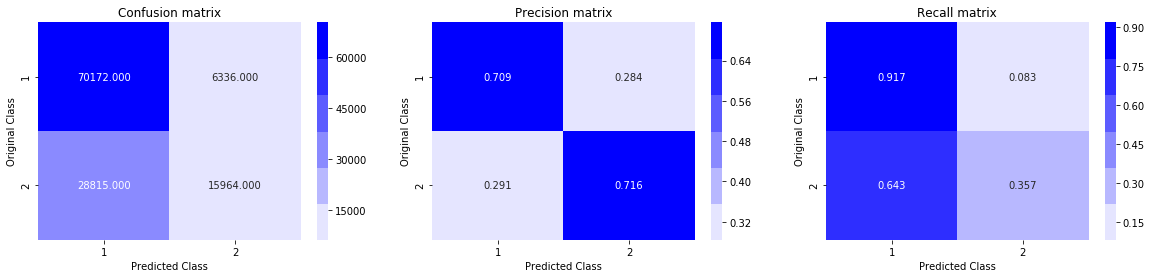

In [22]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [23]:
# hyperparameter tuning for max_depth and min_child_weight
min_logloss = float("Inf")
best_params = None

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3, 10)
    for min_child_weight in range(1, 5)
]

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        d_train,
        seed=42,
        nfold=10,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth,min_child_weight)

CV with max_depth=3, min_child_weight=1
	LogLoss 0.6737559999999999 for 9 rounds
CV with max_depth=3, min_child_weight=2
	LogLoss 0.6737629999999999 for 9 rounds
CV with max_depth=3, min_child_weight=3
	LogLoss 0.6737624999999999 for 9 rounds
CV with max_depth=3, min_child_weight=4
	LogLoss 0.6737628000000001 for 9 rounds
CV with max_depth=4, min_child_weight=1
	LogLoss 0.6719258 for 9 rounds
CV with max_depth=4, min_child_weight=2
	LogLoss 0.6719314 for 9 rounds
CV with max_depth=4, min_child_weight=3
	LogLoss 0.6719323000000001 for 9 rounds
CV with max_depth=4, min_child_weight=4
	LogLoss 0.6719334 for 9 rounds
CV with max_depth=5, min_child_weight=1
	LogLoss 0.6698331 for 9 rounds
CV with max_depth=5, min_child_weight=2
	LogLoss 0.6698388 for 9 rounds
CV with max_depth=5, min_child_weight=3
	LogLoss 0.6698412 for 9 rounds
CV with max_depth=5, min_child_weight=4
	LogLoss 0.6698445000000001 for 9 rounds
CV with max_depth=6, min_child_weight=1
	LogLoss 0.6679794000000001 for 9 rounds
C

In [24]:
# best max_depth and min_child_weight
print("Best params: {}, {}".format(best_params[0], best_params[1]))

Best params: 9, 1


In [25]:
# hyperparameter tuning for subsample and colsample
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10 for i in range(6,10)]
    for colsample in [i/10 for i in range(6,10)]
]

min_logloss = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        d_train,
        seed=42,
        nfold=10,
        metrics={'logloss'},
        early_stopping_rounds=10
    )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (subsample,colsample)

# Best subsample and colsample 
print("Best params: {}, {}".format(best_params[0], best_params[1]))

CV with subsample=0.9, colsample=0.9
	LogLoss 0.6636297999999999 for 9 rounds
CV with subsample=0.9, colsample=0.8
	LogLoss 0.6640865 for 9 rounds
CV with subsample=0.9, colsample=0.7
	LogLoss 0.6646183999999999 for 9 rounds
CV with subsample=0.9, colsample=0.6
	LogLoss 0.6651883999999999 for 9 rounds
CV with subsample=0.8, colsample=0.9
	LogLoss 0.6636357 for 9 rounds
CV with subsample=0.8, colsample=0.8
	LogLoss 0.6640824999999999 for 9 rounds
CV with subsample=0.8, colsample=0.7
	LogLoss 0.6646852 for 9 rounds
CV with subsample=0.8, colsample=0.6
	LogLoss 0.6651939 for 9 rounds
CV with subsample=0.7, colsample=0.9
	LogLoss 0.66359 for 9 rounds
CV with subsample=0.7, colsample=0.8
	LogLoss 0.6640229000000001 for 9 rounds
CV with subsample=0.7, colsample=0.7
	LogLoss 0.6646728 for 9 rounds
CV with subsample=0.7, colsample=0.6
	LogLoss 0.6652055000000001 for 9 rounds
CV with subsample=0.6, colsample=0.9
	LogLoss 0.6635837 for 9 rounds
CV with subsample=0.6, colsample=0.8
	LogLoss 0.664

In [26]:
# hyperparameter tuning for gamma
min_logloss = float("Inf")
best_params = None

gridsearch_params=[gamma
    for gamma in [i/10.0 for i in range(0,5)]]

for gamma in gridsearch_params:
    print("CV with gamma={}".format(gamma))

    # We update our parameters
    params['gamma'] = gamma

    # Run and time CV
    cv_results = xgb.cv(
            params,
            d_train,
            seed=42,
            nfold=10,
            metrics=['logloss'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = gamma

# Best hyperparameter gamma 
print("Best params: {}".format(best_params))

CV with gamma=0.0
	LogLoss 0.6652302999999999 for 9 rounds
CV with gamma=0.1
	LogLoss 0.6652300999999999 for 9 rounds
CV with gamma=0.2
	LogLoss 0.6652292000000001 for 9 rounds
CV with gamma=0.3
	LogLoss 0.6652285000000001 for 9 rounds
CV with gamma=0.4
	LogLoss 0.6652266000000001 for 9 rounds
Best params: 0.4


In [27]:
# hyperparameter tuning for reg_alpha
min_logloss = float("Inf")
best_params = None


for reg_alpha in [1e-5, 1e-2, 0.1, 1, 100]:
    print("CV with reg_alpha={}".format(reg_alpha))

    # We update our parameters
    params['reg_alpha'] = reg_alpha

    # Run and time CV
    cv_results = xgb.cv(
            params,
            d_train,
            seed=42,
            nfold=10,
            metrics=['logloss'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = reg_alpha

# best reg_alpha        
print("Best params: {}".format(best_params))

CV with reg_alpha=1e-05
	LogLoss 0.6652265000000002 for 9 rounds
CV with reg_alpha=0.01
	LogLoss 0.6652272 for 9 rounds
CV with reg_alpha=0.1
	LogLoss 0.6652354 for 9 rounds
CV with reg_alpha=1
	LogLoss 0.6653066999999999 for 9 rounds
CV with reg_alpha=100
	LogLoss 0.668479 for 9 rounds
Best params: 1e-05


In [28]:
# hyperparameter tuning for number of estimators
min_logloss = float("Inf")
best_params = None

for n_estimators in [80, 95, 100, 140, 175, 250, 400, 600, 700, 900]:
    print("CV with n_estimators={}".format(n_estimators))

    # We update our parameters
    params['n_estimators'] = n_estimators

    # Run and time CV
    cv_results = xgb.cv(
            params,
            d_train,
            seed=42,
            nfold=10,
            metrics=['logloss'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = n_estimators
# Best n_estimators
print("Best params: {}".format(best_params))

CV with n_estimators=80
	LogLoss 0.668479 for 9 rounds
CV with n_estimators=95
	LogLoss 0.668479 for 9 rounds
CV with n_estimators=100
	LogLoss 0.668479 for 9 rounds
CV with n_estimators=140
	LogLoss 0.668479 for 9 rounds
CV with n_estimators=175
	LogLoss 0.668479 for 9 rounds
CV with n_estimators=250
	LogLoss 0.668479 for 9 rounds
CV with n_estimators=400
	LogLoss 0.668479 for 9 rounds
CV with n_estimators=600
	LogLoss 0.668479 for 9 rounds
CV with n_estimators=700
	LogLoss 0.668479 for 9 rounds
CV with n_estimators=900
	LogLoss 0.668479 for 9 rounds
Best params: 80


In [31]:
# Hyperparameter tuned model with best hyperparameters found using CV and reduced test log-loss.

import xgboost as xgb
params= {}

params['n_estimators'] = 80
params['min_child_weight'] = 1
params['subsample'] = 0.6
params['colsample_bytree'] = 0.9
params['gamma'] = 0.4
params['reg_alpha'] = 1e-05
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.01
params['max_depth'] = 9

d_train = xgb.DMatrix(x_train_tfidf, label=y_train)
d_test = xgb.DMatrix(x_test_tfidf, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)


xgdmat = xgb.DMatrix(x_train_tfidf,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.691453	valid-logloss:0.691502
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.675253	valid-logloss:0.675816
[20]	train-logloss:0.661489	valid-logloss:0.662472
[30]	train-logloss:0.649662	valid-logloss:0.651078
[40]	train-logloss:0.639192	valid-logloss:0.641031
[50]	train-logloss:0.630167	valid-logloss:0.632446
[60]	train-logloss:0.622113	valid-logloss:0.624772
[70]	train-logloss:0.614719	valid-logloss:0.617788
[80]	train-logloss:0.608365	valid-logloss:0.611798
[90]	train-logloss:0.602546	valid-logloss:0.606331
[100]	train-logloss:0.597242	valid-logloss:0.601361
[110]	train-logloss:0.59255	valid-logloss:0.597021
[120]	train-logloss:0.588085	valid-logloss:0.592871
[130]	train-logloss:0.583899	valid-logloss:0.589016
[140]	train-logloss:0.580244	valid-logloss:0.585638
[150]	train-logloss:0.576675	valid-logloss:0.582379
[160]	train-logloss:0.573457	

Total number of data points : 121287


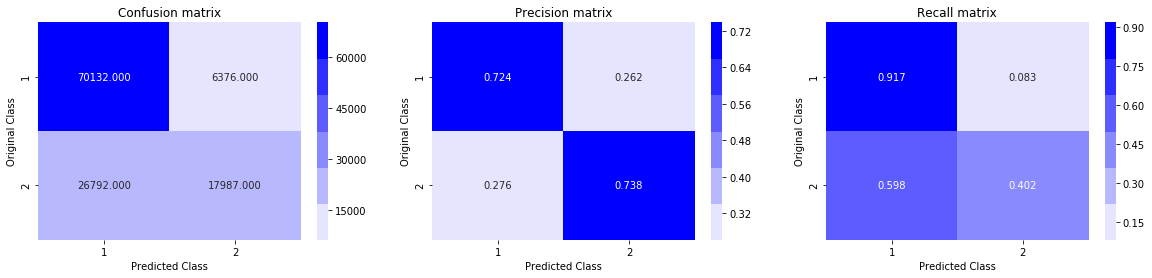

In [32]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> Conclusion </h1>

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.
